# Soy price prediction with multivariate series. 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


# Datasets used for this project are. Historical prices of Soy in Argentina (Rosario market). Inflation in USA (impacts in dolar values all over the world). Oil Prices (Brent and WTI). 

## I will merge all the datasets and pair them with the main soy price dataset which has records since 2004.
### Special focus on dates as they will be important to merge datasets.

In [101]:
dataset = pd.read_csv('./datasetRofex4.csv', parse_dates=True)
inflation = pd.read_csv('./inflacionusa.csv', parse_dates=True, names=['year', 'month', 'inflation'])
brent = pd.read_csv('./brent-daily.csv', parse_dates=True)
wti = pd.read_csv('./wti-daily.csv', parse_dates=True)

In [102]:
dataset.head()

,Id,Fecha,Open,High,Low,Last,Cierre,Aj.Dif.,Mon.,OI.Vol.,OI.Dif.,Vol.Ope.,Unidad,DolarB.N.,DolarItau.,Dif.Sem
0,1,05/01/2004 12:00:00 a.m.,0.0,0.0,0.0,0.0,221.0,13.0,D,0,0,0,TONS,2.92,2.905,-221.0
1,2,06/01/2004 12:00:00 a.m.,0.0,0.0,0.0,0.0,221.0,0.0,D,0,0,0,TONS,2.88,2.87,-221.0
2,3,07/01/2004 12:00:00 a.m.,0.0,0.0,0.0,0.0,219.0,-2.0,D,0,0,0,TONS,2.865,2.882,-219.0
3,4,08/01/2004 12:00:00 a.m.,0.0,0.0,0.0,0.0,220.0,1.0,D,0,0,0,TONS,2.887,2.884,-220.0
4,5,09/01/2004 12:00:00 a.m.,0.0,0.0,0.0,0.0,220.0,0.0,D,0,0,0,TONS,2.892,2.9,-220.0


In [103]:
brent.head()

,Date,Price
0,02-01-04,29.55
1,05-01-04,32.30
2,06-01-04,31.20
3,07-01-04,30.99
4,08-01-04,31.11


In [104]:
inflation.head()

,year,month,inflation
0,2004,1,1.9
1,2004,2,1.7
2,2004,3,1.7
3,2004,4,2.3
4,2004,5,3.1


In [105]:
brent.head()

,Date,Price
0,02-01-04,29.55
1,05-01-04,32.30
2,06-01-04,31.20
3,07-01-04,30.99
4,08-01-04,31.11


In [106]:
wti.head()

,Date,Price
0,05-01-04,33.71
1,06-01-04,33.54
2,07-01-04,33.57
3,08-01-04,34.27
4,09-01-04,34.38


In [107]:
dataset['Date'] = pd.to_datetime(dataset['Fecha'], dayfirst=True)
brent['Date'] = pd.to_datetime(brent['Date'], yearfirst=False)
wti['Date'] = pd.to_datetime(wti['Date'],yearfirst=False)

In [108]:
brent['year'] = brent['Date'].dt.year
wti['year'] = wti['Date'].dt.year
dataset['Year'] = dataset['Date'].dt.year
dataset['month'] = dataset['Date'].dt.month

In [109]:
mask_brent = brent['year']<2004
mask_wti = wti['year']<2004

In [110]:
brent = brent.loc[~mask_brent,:].reset_index().drop(['index'], axis=1)
wti = wti.loc[~mask_wti,:].reset_index().drop(['index'], axis=1)

In [111]:
df = pd.merge(dataset, brent, how='left', on='Date')

In [112]:
df = pd.merge(df, wti, how='left', on='Date')

In [113]:
df.drop(['Fecha', 'year_x', 'year_y', 'Unidad', 'Dif.Sem', 'Open', 'High', 'Low', 'Last', 'OI.Vol.', 'OI.Dif.', 'Vol.Ope.', 'Mon.', 'Aj.Dif.'], axis=1, inplace=True)

In [114]:
df.head()

,Id,Cierre,DolarB.N.,DolarItau.,Date,Year,month,Price_x,Price_y
0,1,221.0,2.92,2.905,2004-01-05,2004,1,NaN,NaN
1,2,221.0,2.88,2.87,2004-01-06,2004,1,39.05,42.33
2,3,219.0,2.865,2.882,2004-01-07,2004,1,35.58,38.56
3,4,220.0,2.887,2.884,2004-01-08,2004,1,NaN,NaN
4,5,220.0,2.892,2.9,2004-01-09,2004,1,40.96,43.89


In [115]:
df['ik'] = df['Year'].astype(str)+'-'+df['month'].astype(str)

In [116]:
inflation['ik'] = inflation['year'].astype(str)+'-'+inflation['month'].astype(str)

In [117]:
df = pd.merge(df, inflation, how='left', on='ik')

In [118]:
df.rename(columns={'inflation': 'USA_Inflation', 'Cierre': 'Closing', 'DolarB.N.':'Dolar_BN', 'DolarItau.':'Dolar_Itau', 'Price_x':'Brent', 'Price_y':'WTI'}, inplace=True)

In [119]:
cols = ['Id', 'Date', 'Dolar_BN', 'Dolar_Itau', 'Brent', 'WTI', 'USA_Inflation', 'Closing']

In [120]:
df = df[cols]

In [121]:
df.isna().sum()

Id                 0
Date               0
Dolar_BN           0
Dolar_Itau         7
Brent            507
WTI              533
USA_Inflation      0
Closing            0
dtype: int64

## The dataset has some nan values I'd like to fill with the previous value.

In [122]:
df.fillna(method='ffill', inplace=True)
df.isna().sum()

Id               0
Date             0
Dolar_BN         0
Dolar_Itau       0
Brent            1
WTI              1
USA_Inflation    0
Closing          0
dtype: int64

### Being Soy a commodity, local dolar prices wont affect it's prices so I'll drop those.

In [123]:
df = df.set_index(['Id'])

In [124]:
df.drop(['Dolar_Itau', 'Dolar_BN'], axis=1, inplace=True)

## Plotting the time series will help me see if there is correlation within the data

In [125]:
df.drop(df.index[0],inplace=True)

In [126]:
df[[	'Brent',	'WTI',	'USA_Inflation',	'Closing']] = df[[	'Brent',	'WTI',	'USA_Inflation',	'Closing']].astype(float)

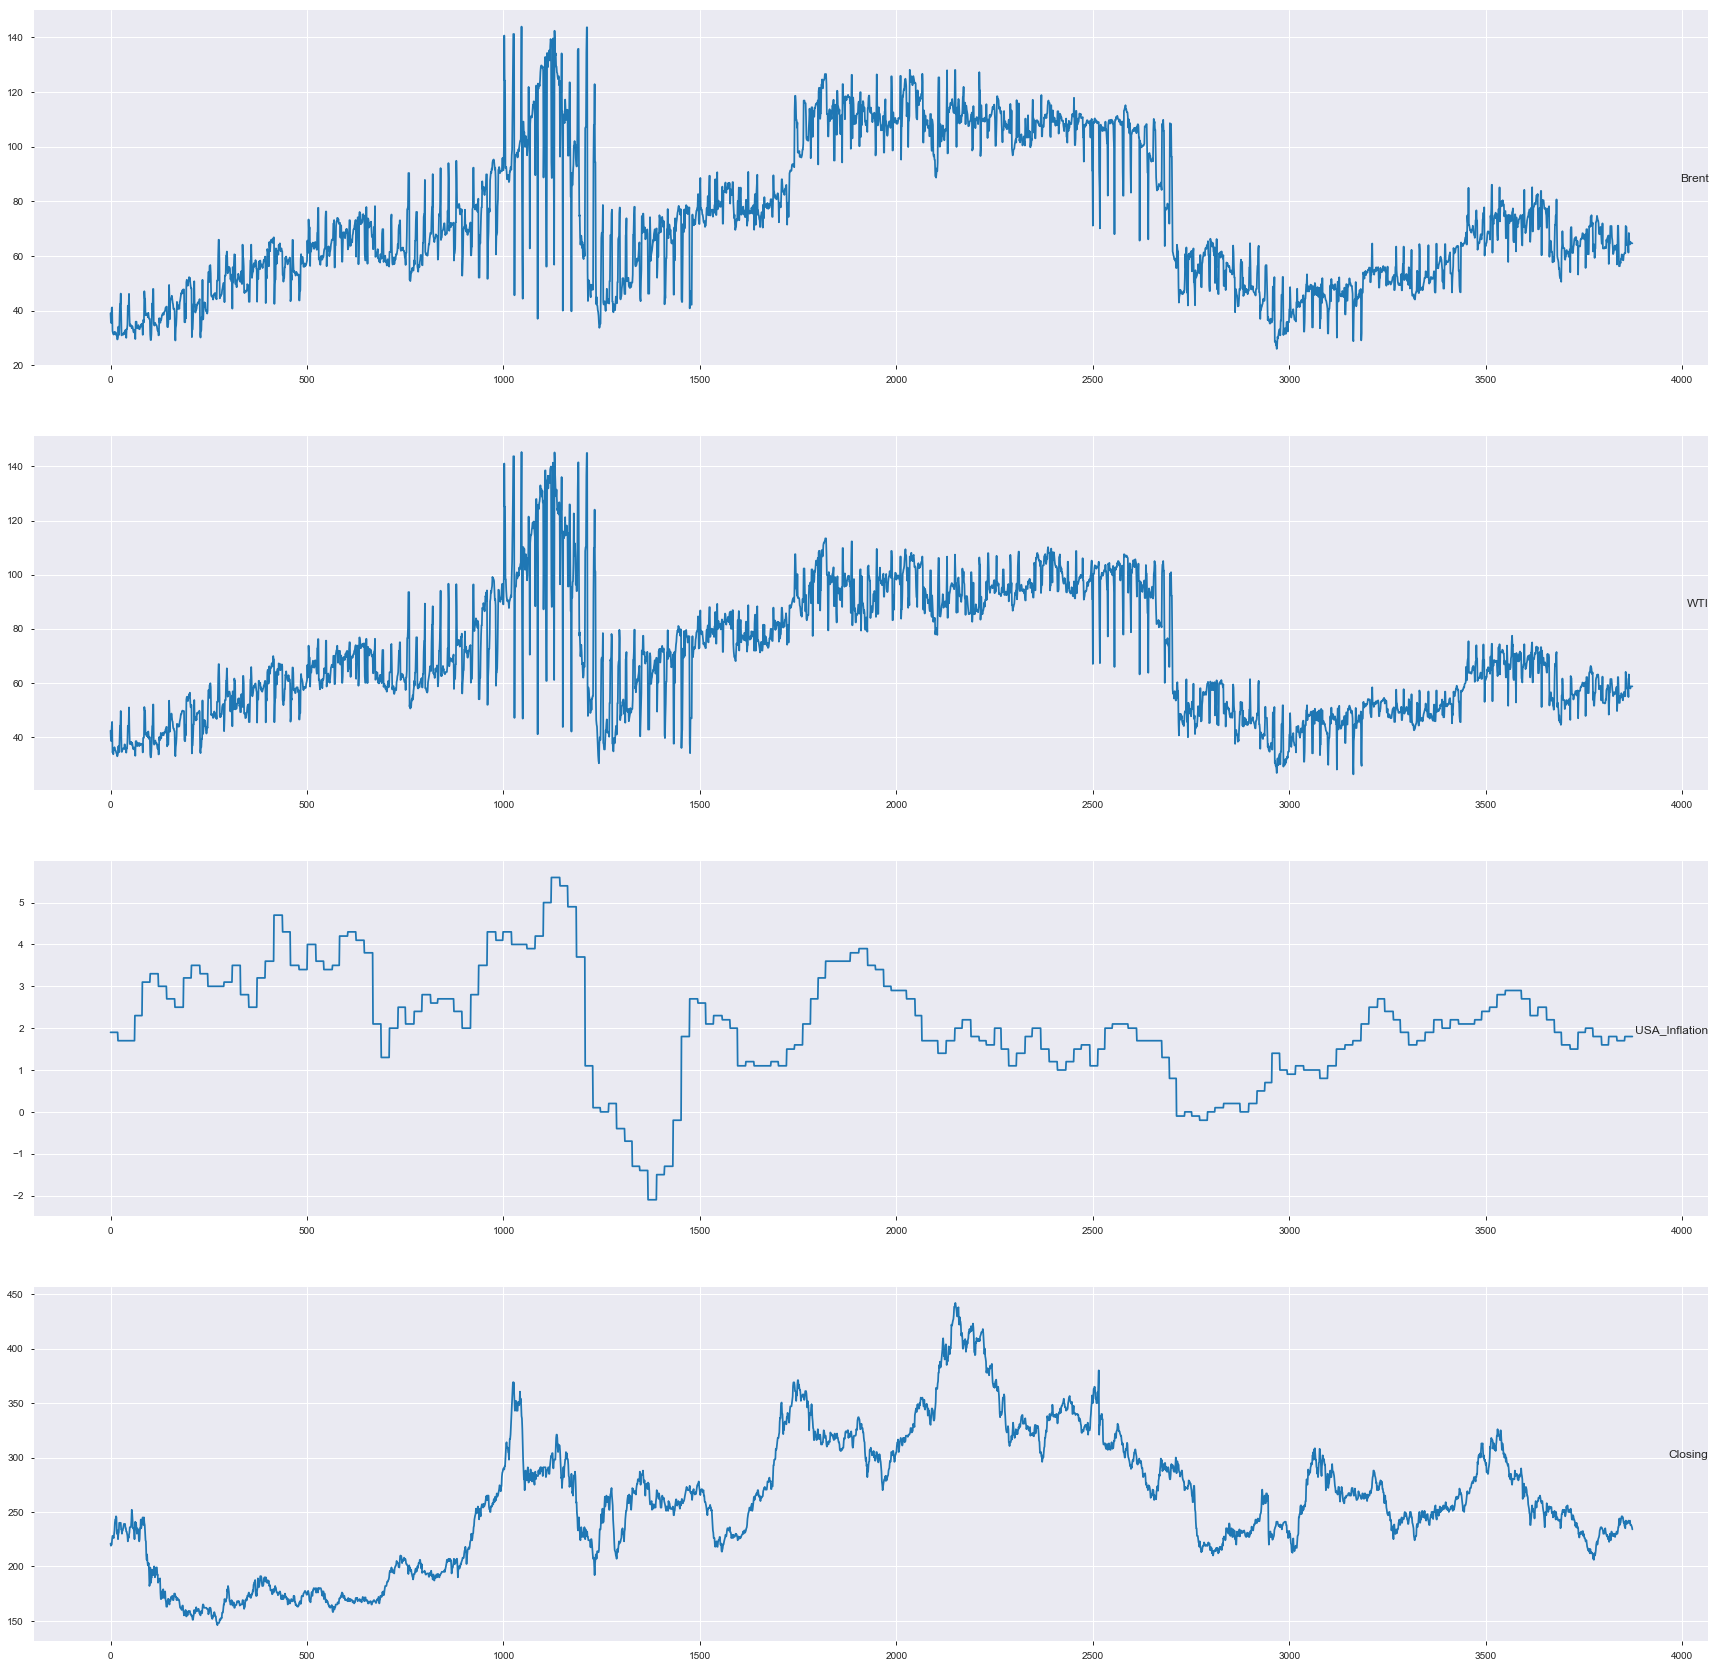

In [127]:
from matplotlib import pyplot

values = df.values

groups = [1, 2, 3, 4]
i = 1

pyplot.figure(figsize=[30,30])
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(df.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [128]:
df.corr()

,Brent,WTI,USA_Inflation,Closing
Brent,1.000000,0.968915,0.238208,0.690708
WTI,0.968915,1.000000,0.292451,0.596606
USA_Inflation,0.238208,0.292451,1.000000,-0.150621
Closing,0.690708,0.596606,-0.150621,1.000000


### There is a strong correlation between oil prices an soy prices

## Without nan values the dataset is completed. I'm going to save it as a csv for the modeling phase.

In [129]:
df.to_csv('./dataset.csv', header=True)